### Finetune GPT-4o-mini

**Steps:**
1. Prepare training data
2. Validate training data
3. Finetune model
4. Use the finetuned model

### 1. Prepare training data

In [1]:
from datasets import load_dataset
import pandas as pd
import json

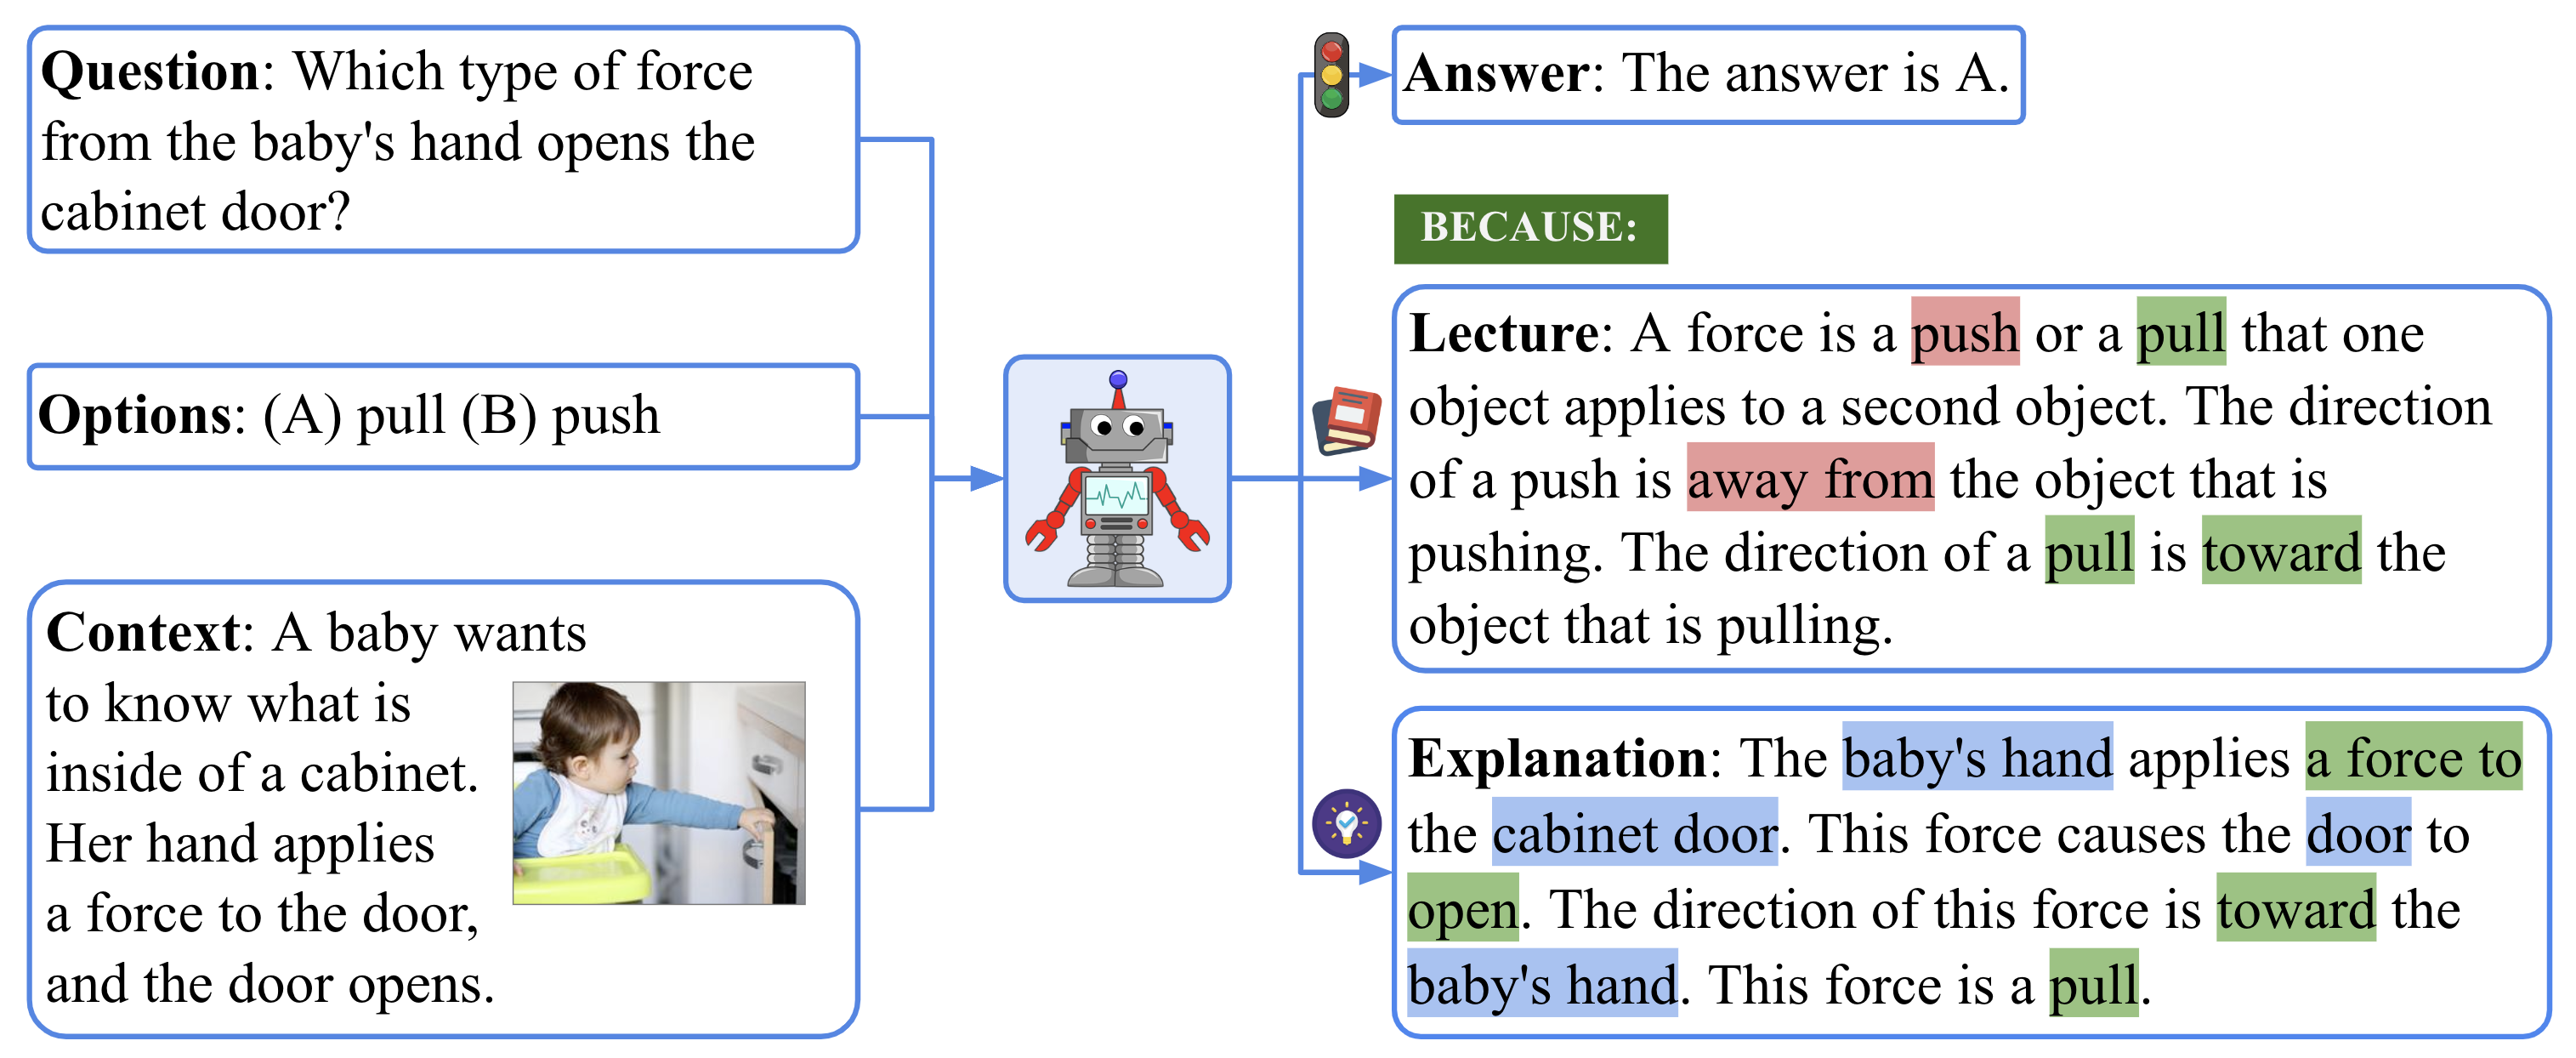

In [2]:
from IPython.display import Image
Image("https://scienceqa.github.io/img/scienceqa.png")

In [3]:
dataset = load_dataset('derek-thomas/ScienceQA')
dataset

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})

In [4]:
dft = pd.DataFrame(dataset['train'][:10])
dft.head(2)

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Which of these states is farthest north?,"[West Virginia, Louisiana, Arizona, Oklahoma]",0,,closed choice,grade2,social science,geography,Geography,Read a map: cardinal directions,"Maps have four cardinal directions, or main di...","To find the answer, look at the compass rose. ..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Identify the question that Tom and Justin's ex...,[Do ping pong balls stop rolling along the gro...,1,The passage below describes an experiment. Rea...,closed choice,grade8,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,


In [ ]:
{"messages": [
    {"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, 
    {"role": "user", "content": "What's the capital of France?"}, 
    {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}


In [5]:
choice_prefixes = [chr(ord('A') + i) for i in range(26)] # A-Z
def format_options(row):
    return ' '.join([f'({c}) {o}' for c, o in zip(choice_prefixes, row['choices'])])

In [6]:
dft['choices_formatted'] = dft.apply(format_options, axis=1)
print(dft['choices'][0])
print(dft['choices_formatted'][0])

['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma']
(A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma


In [7]:
map_dct = {0: "A", 1: "B", 2: "C", 3: "D"}
dft.replace({"answer": map_dct}, inplace=True)
dft.head(2)

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution,choices_formatted
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Which of these states is farthest north?,"[West Virginia, Louisiana, Arizona, Oklahoma]",A,,closed choice,grade2,social science,geography,Geography,Read a map: cardinal directions,"Maps have four cardinal directions, or main di...","To find the answer, look at the compass rose. ...",(A) West Virginia (B) Louisiana (C) Arizona (D...
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Identify the question that Tom and Justin's ex...,[Do ping pong balls stop rolling along the gro...,B,The passage below describes an experiment. Rea...,closed choice,grade8,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,,(A) Do ping pong balls stop rolling along the ...


In [8]:
def combine_columns(row):
    ret = "Context: " + row['lecture'] + ", " + "Question: " + row['question'] + ", " + "Options: " + row['choices_formatted']
    return ret

In [9]:
dft['user_content'] = dft.apply(combine_columns, axis=1)
dft['user_content'][0]

'Context: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map., Question: Which of these states is farthest north?, Options: (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma'

In [11]:
DEFAULT_SYSTEM_PROMPT = """
Role: Science Teacher Assistant

Task: Respond accurately to multiple-choice science questions provided by the teacher.

Instructions:
1. For each question, you will be given up to four answer choices labeled A, B, C, or D.
2. Carefully evaluate the question and select the most appropriate answer from the provided choices.

Output: Return only the letter corresponding to the correct answer (A, B, C, or D). 
"""

In [12]:
def get_example(user_content, answer):  
    return {  
        "messages": [  
            {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},  
            {"role": "user", "content": user_content},  
            {"role": "assistant", "content": answer},  
        ]  
    }

In [13]:
with open("train.jsonl", "w") as f:  
    for i, row in list(dft.iterrows()):  
        question = row["user_content"]  
        answer = row["answer"]  
        example = get_example(question, answer)  
        example_str = json.dumps(example)  
        f.write(example_str + "\n")

In [14]:
!head -n 1 train.jsonl

{"messages": [{"role": "system", "content": "\n\nRole: Science Teacher Assistant\n\nTask: Respond accurately to multiple-choice science questions provided by the teacher.\n\nInstructions:\n1. For each question, you will be given up to four answer choices labeled A, B, C, or D.\n2. Carefully evaluate the question and select the most appropriate answer from the provided choices.\n\nOutput: Return only the letter corresponding to the correct answer (A, B, C, or D). \n"}, {"role": "user", "content": "Context: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map., Question: Which of these states is farthest north?, Options: (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma"}, {"role": "assistan

In [15]:
!tail -n 1 train.jsonl

{"messages": [{"role": "system", "content": "\n\nRole: Science Teacher Assistant\n\nTask: Respond accurately to multiple-choice science questions provided by the teacher.\n\nInstructions:\n1. For each question, you will be given up to four answer choices labeled A, B, C, or D.\n2. Carefully evaluate the question and select the most appropriate answer from the provided choices.\n\nOutput: Return only the letter corresponding to the correct answer (A, B, C, or D). \n"}, {"role": "user", "content": "Context: A food web is a model.\nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.\nArrows show how matter moves.\nA food web has arrows that point from one organism to another. Each arrow show

### 2. Validate training data

In [16]:
from collections import defaultdict

In [17]:
with open("train.jsonl", 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 10
First example:
{'role': 'system', 'content': '\n\nRole: Science Teacher Assistant\n\nTask: Respond accurately to multiple-choice science questions provided by the teacher.\n\nInstructions:\n1. For each question, you will be given up to four answer choices labeled A, B, C, or D.\n2. Carefully evaluate the question and select the most appropriate answer from the provided choices.\n\nOutput: Return only the letter corresponding to the correct answer (A, B, C, or D). \n'}
{'role': 'user', 'content': 'Context: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map., Question: Which of these states is farthest north?, Options: (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma'}
{'

In [18]:
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [19]:
import tiktoken # for token counting
import numpy as np

encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [49]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 65536 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 65536 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 209, 594
mean / median: 369.1, 362.0
p5 / p95: 229.7, 498.59999999999997

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 65536 token limit, they will be truncated during fine-tuning


In [21]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~3691 tokens that will be charged for during training
By default, you'll train for 10 epochs on this dataset
By default, you'll be charged for ~36910 tokens


https://openai.com/pricing

In [23]:
36910* (0.3/1000000)

0.011073

### 3. Finetune model


In [24]:
from openai import OpenAI
client = OpenAI()

In [25]:
response = client.files.create(
    file=open("train.jsonl", "rb"),
    purpose="fine-tune"
)
print(response)

FileObject(id='file-kYqe4rYu4zgptjKNuuLhaK1E', bytes=17835, created_at=1724195140, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [26]:
file_id = response.id
print(file_id)

file-kYqe4rYu4zgptjKNuuLhaK1E


In [ ]:
# response = client.files.delete(file_id)
# response

In [27]:
response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-4o-mini-2024-07-18",
    hyperparameters={"n_epochs": 2}
    #validation_file
)

print("Fine-tune job is started")
ft_job_id = response.id


Fine-tune job is started


In [28]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=ft_job_id, limit=10)
response

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-yJpcV9bSdWYFSkY3iy7dbw3x', created_at=1724195231, level='info', message='Validating training file: file-kYqe4rYu4zgptjKNuuLhaK1E', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-B9OoHvqwIgDKuwXaaGQJq2AE', created_at=1724195231, level='info', message='Created fine-tuning job: ftjob-J4WMDgUX3BRtTvq2gZS6ghoO', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)

In [ ]:
#dir(response)

In [34]:
response = client.fine_tuning.jobs.retrieve(ft_job_id)
print(response)

FineTuningJob(id='ftjob-J4WMDgUX3BRtTvq2gZS6ghoO', created_at=1724195231, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal::9ySIscvb', finished_at=1724195504, hyperparameters=Hyperparameters(n_epochs=2, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-skZHDYN1xmsxAl538Hbgo1ud', result_files=['file-W8QeK6Of21SRwZ2IpbdIT11d'], seed=1674037635, status='succeeded', trained_tokens=7284, training_file='file-kYqe4rYu4zgptjKNuuLhaK1E', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)


In [35]:
result_files = response.result_files
result_files

['file-W8QeK6Of21SRwZ2IpbdIT11d']

### 4. Use the finetuned model

In [36]:
fine_tuned_model = response.fine_tuned_model
fine_tuned_model

'ft:gpt-4o-mini-2024-07-18:personal::9ySIscvb'

In [39]:
user_content = """
Context: Chemical changes and physical changes are two common ways matter can change.
\nIn a chemical change, the type of matter changes. The types of matter before and after 
a chemical change are always different.\nBurning a piece of paper is a chemical change. 
When paper gets hot enough, it reacts with oxygen in the air and burns. The paper and 
oxygen change into ash and smoke.\nIn a physical change, the type of matter stays the 
same. The types of matter before and after a physical change are always the same.
\nCutting a piece of paper is a physical change. The cut pieces are still made of paper.
\nA change of state is a type of physical change. For example, ice melting is a physical 
change. Ice and liquid water are made of the same type of matter: water., 

Question: Complete the sentence.\nSewing an apron is a ()., 

Options: (A) chemical change (B) physical change

"""

In [40]:
completion = client.chat.completions.create(
  model=fine_tuned_model,
  messages=[
    {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
    {"role": "user", "content": user_content}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='B', role='assistant', function_call=None, tool_calls=None, refusal=None)


In [42]:
user_content = """
Context: A food web is a model.\nA food web shows where organisms in an ecosystem get 
their food. Models can make things in nature easier to understand because models can 
represent complex things in a simpler way. If a food web showed every organism in an 
ecosystem, the food web would be hard to understand. So, each food web shows how some 
organisms in an ecosystem can get their food.\nArrows show how matter moves.
\nA food web has arrows that point from one organism to another. Each arrow shows the 
direction that matter moves when one organism eats another organism. An arrow starts from 
the organism that is eaten. The arrow points to the organism that is doing the eating.
\nAn organism in a food web can have more than one arrow pointing from it. This shows that 
the organism is eaten by more than one other organism in the food web.\nAn organism in a 
food web can also have more than one arrow pointing to it. This shows that the organism 
eats more than one other organism in the food web., 

Question: Which of these organisms contains matter that was once part of the phytoplankton?, 

Options: (A) black rockfish (B) sea otter

"""

In [43]:
completion = client.chat.completions.create(
  model=fine_tuned_model,
  messages=[
    {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
    {"role": "user", "content": user_content}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='A', role='assistant', function_call=None, tool_calls=None, refusal=None)


In [45]:
client.models.delete(fine_tuned_model)

ModelDeleted(id='ft:gpt-4o-mini-2024-07-18:personal::9ySIscvb', deleted=True, object='model')

**Advantages**
- Higher quality results than prompting
- Ability to train on more examples than can fit in a prompt
- Token savings due to shorter prompts
- Lower latency requests


**Disadvantages**
- Expensive & handware
- more LLMOps

In [46]:
!tail -n 1 train.jsonl

{"messages": [{"role": "system", "content": "\n\nRole: Science Teacher Assistant\n\nTask: Respond accurately to multiple-choice science questions provided by the teacher.\n\nInstructions:\n1. For each question, you will be given up to four answer choices labeled A, B, C, or D.\n2. Carefully evaluate the question and select the most appropriate answer from the provided choices.\n\nOutput: Return only the letter corresponding to the correct answer (A, B, C, or D). \n"}, {"role": "user", "content": "Context: A food web is a model.\nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.\nArrows show how matter moves.\nA food web has arrows that point from one organism to another. Each arrow show